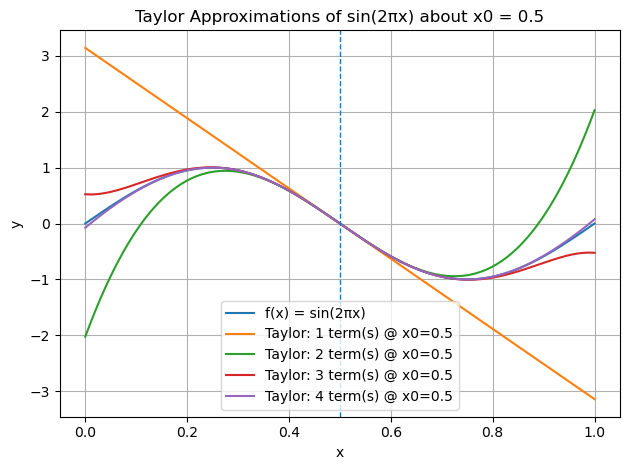

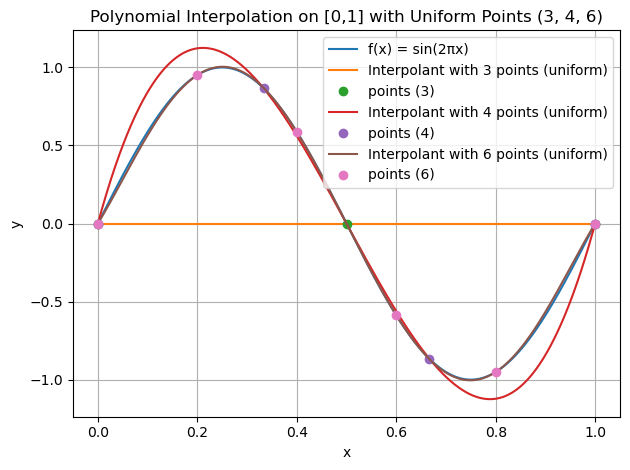

Max errors on a dense grid:
  Taylor with 1 term(s): 3.141593e+00
  Taylor with 2 term(s): 2.026120e+00
  Taylor with 3 term(s): 5.240439e-01
  Taylor with 4 term(s): 7.522062e-02
  Interpolant with 3 points: 9.999988e-01
  Interpolant with 4 points: 2.553541e-01
  Interpolant with 6 points: 2.675414e-02


In [2]:
#########################
#Types of interpolation
#
# There will be the tools for approximaiton we will use the most
#
# Andrew Christlieb
# CMSE 821
# Fall 2025
#
#Reason: Demonstrating the two key types of approximation 
#
#Visual demo: approximating sin(2πx) on [0,1]
#
# - Taylor polynomials about x0 = 0.5 with 1, 2, 3, 4 nonzero terms
#
# - Polynomial interpolants with uniformly spaced points: 3, 4, 6
#
# - Chebyshev interpolation with 3, 4 and 6 poitns.  (non-uniform spaceing or points)
#
# - Hermite interpolation using f and f' with 2 points then 5 points
#
# Key observaiton is that changeing 
#
# Requirements: matplotlib, numpy (no seaborn)

import numpy as np
import math
import matplotlib.pyplot as plt

# -------------------- Target function --------------------
def f(x):
    return np.sin(2*np.pi*x)

# -------------------- Taylor (about x0=0.5) --------------------
def taylor_nonzero_terms(x, m_terms, x0=0.5):
    """
    Return the Taylor approximation to sin(2πx) about x0 using the first m_terms
    NONZERO terms. For sin about x0=0.5, only odd powers contribute.
    Term m uses power p = 2*m + 1.
    """
    k = 2*np.pi
    x = np.asarray(x, dtype=float)
    s = np.zeros_like(x)
    for m in range(m_terms):
        p = 2*m + 1                      # odd power
        coef = ((-1)**(m+1)) * (k**p) / math.factorial(p)
        s = s + coef * (x - x0)**p
    return s

# -------------------- Interpolation (Newton form) --------------------
def divided_differences(xnodes, ynodes):
    xnodes = np.array(xnodes, dtype=float)
    a = np.array(ynodes, dtype=float).copy()
    n = len(xnodes)
    for j in range(1, n):
        a[j:n] = (a[j:n] - a[j-1:n-1]) / (xnodes[j:n] - xnodes[0:n-j])
    return a  # Newton coefficients

def newton_eval_vectorized(x, xnodes, coeffs):
    x = np.asarray(x, dtype=float)
    p = np.zeros_like(x, dtype=float)
    # Horner-like evaluation for Newton basis
    for k in range(len(coeffs)-1, -1, -1):
        p = coeffs[k] + (x - xnodes[k]) * p
    return p

def interpolant_values(xx, m_points):
    """
    Build polynomial interpolant using m_points uniformly spaced nodes on [0,1],
    and evaluate it on grid xx.
    """
    nodes = np.linspace(0.0, 1.0, m_points)
    values = f(nodes)
    coeffs = divided_differences(nodes, values)
    return newton_eval_vectorized(xx, nodes, coeffs), nodes, values

# -------------------- Plotting --------------------
xx = np.linspace(0.0, 1.0, 1000)
yy = f(xx)

# Figure 1: Taylor with 1, 2, 3, 4 nonzero terms
terms_list = [1, 2, 3, 4]
plt.figure()
plt.plot(xx, yy, label="f(x) = sin(2πx)")
for m in terms_list:
    approx = taylor_nonzero_terms(xx, m, x0=0.5)
    plt.plot(xx, approx, label=f"Taylor: {m} term(s) @ x0=0.5")
plt.axvline(0.5, linestyle="--", linewidth=1)
plt.title("Taylor Approximations of sin(2πx) about x0 = 0.5")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Figure 2: Interpolants with 3, 4, 6 uniformly spaced points
node_counts = [3, 4, 6]
plt.figure()
plt.plot(xx, yy, label="f(x) = sin(2πx)")
for m in node_counts:
    interp_vals, nodes, values = interpolant_values(xx, m)
    plt.plot(xx, interp_vals, label=f"Interpolant with {m} points (uniform)")
    plt.plot(nodes, values, marker="o", linestyle="", label=f"points ({m})")
plt.title("Polynomial Interpolation on [0,1] with Uniform Points (3, 4, 6)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# (Optional) print max errors for quick comparison
def max_err(y_true, y_approx): 
    return float(np.max(np.abs(y_true - y_approx)))

print("Max errors on a dense grid:")
for m in terms_list:
    err = max_err(yy, taylor_nonzero_terms(xx, m, x0=0.5))
    print(f"  Taylor with {m} term(s): {err:.6e}")
for m in node_counts:
    ivals, _, _ = interpolant_values(xx, m)
    err = max_err(yy, ivals)
    print(f"  Interpolant with {m} points: {err:.6e}")


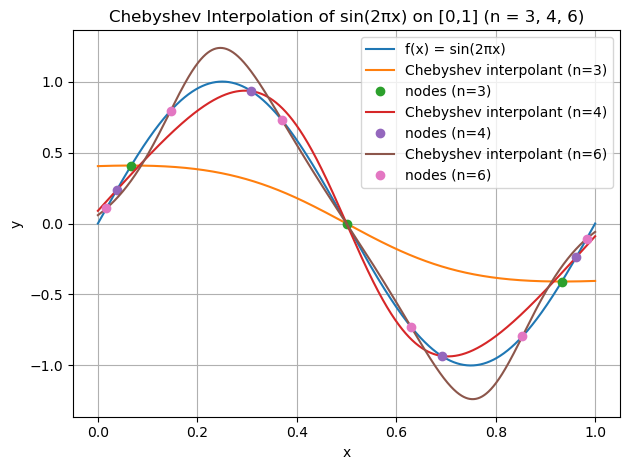

Chebyshev interpolation max errors:
  n = 3: 6.536049e-01
  n = 4: 1.679804e-01
  n = 6: 2.377656e-01


In [7]:
# -------------------------------------------------------------
# Chebyshev interpolation of f(x) = sin(2πx) on [0,1]
# Using Chebyshev (first-kind) nodes with n = 3, 4, 6 points
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Target function
def f_sin2pi(x):
    return np.sin(2 * np.pi * x)

# Chebyshev (first-kind) nodes mapped to [a,b]
def cheb_nodes_first_kind(n, a=0.0, b=1.0):
    k = np.arange(1, n + 1)
    # nodes on [-1,1]
    x_std = np.cos((2*k - 1) * np.pi / (2 * n))
    # affine map to [a,b]
    return (x_std + 1) * (b - a) / 2 + a

# Barycentric weights for Chebyshev first-kind nodes
def cheb_first_kind_weights(n):
    # 0-based indexing -> (-1)^k
    return (-1.0) ** np.arange(n)

# Barycentric evaluation (robust, point-by-point)
def barycentric_eval(x, xk, yk, wk):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x, dtype=float)
    for idx, xv in np.ndenumerate(x):
        diffs = xv - xk
        hit = np.where(diffs == 0)[0]
        if hit.size:
            out[idx] = yk[hit[0]]
        else:
            terms = wk / diffs
            out[idx] = np.sum(terms * yk) / np.sum(terms)
    return out

# Build and evaluate Chebyshev interpolant of size n at grid xx
def cheb_interpolant_values(xx, n, a=0.0, b=1.0):
    xk = cheb_nodes_first_kind(n, a=a, b=b)
    yk = f_sin2pi(xk)
    wk = cheb_first_kind_weights(n)
    return barycentric_eval(xx, xk, yk, wk), xk, yk

# Grid and truth
xx = np.linspace(0.0, 1.0, 1200)
yy = f_sin2pi(xx)

# Interpolate with 3, 4, 6 Chebyshev points
cheb_counts = [3, 4, 6]

plt.figure()
plt.plot(xx, yy, label="f(x) = sin(2πx)")
for n in cheb_counts:
    yi, xk, yk = cheb_interpolant_values(xx, n)
    plt.plot(xx, yi, label=f"Chebyshev interpolant (n={n})")
    plt.plot(xk, yk, marker="o", linestyle="", label=f"nodes (n={n})")
plt.title("Chebyshev Interpolation of sin(2πx) on [0,1] (n = 3, 4, 6)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# Optional: print max errors for each n
def max_err(y_true, y_approx):
    return float(np.max(np.abs(y_true - y_approx)))

print("Chebyshev interpolation max errors:")
for n in cheb_counts:
    yi, _, _ = cheb_interpolant_values(xx, n)
    print(f"  n = {n}: {max_err(yy, yi):.6e}")


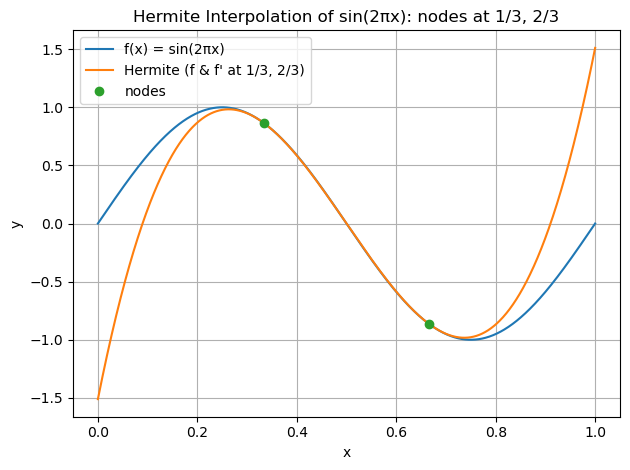

[Hermite: nodes 1/3, 2/3] max error = 1.511043e+00


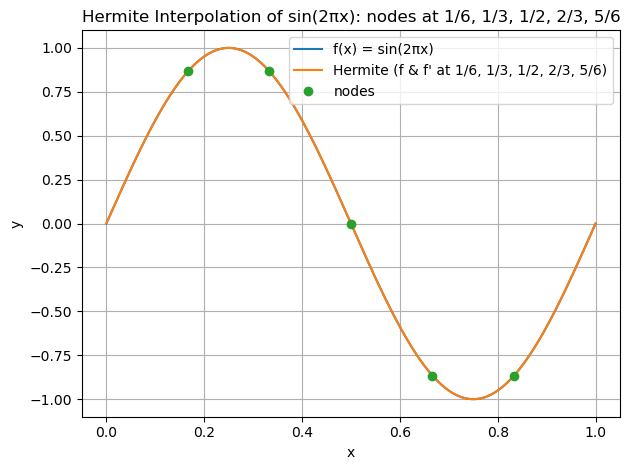

[Hermite: nodes 1/6, 1/3, 1/2, 2/3, 5/6] max error = 1.572380e-03


In [5]:
# -------------------------------------------------------------
# Hermite interpolation demos for f(x) = sin(2πx) on [0,1]
# Case A: nodes = [1/3, 2/3], match f and f' at each node (cubic)
# Case B: nodes = [1/6, 1/3, 1/2, 2/3, 5/6], match f and f' (degree ≤ 9)
# -------------------------------------------------------------

import numpy as np
import math
import matplotlib.pyplot as plt

# Target function and derivative
def f_sin2pi(x):
    return np.sin(2 * np.pi * x)

def df_sin2pi(x):
    return 2 * np.pi * np.cos(2 * np.pi * x)

def hermite_interpolant(xx, f, df, nodes):
    """
    Construct the Hermite interpolant using a generalized divided-difference table
    with node repetition for derivative constraints. Returns H(xx).

    nodes: list/array of distinct nodes [x0, x1, ...]
    f: function
    df: derivative of function
    xx: evaluation grid (array-like)
    """
    # Build repeated nodes (each node twice: once for f, once for f')
    z = []
    Q0 = []
    for xi in nodes:
        z.extend([xi, xi])          # repeat node
        Q0.extend([f(xi), f(xi)])   # same f-value in first column
    z = np.array(z, dtype=float)
    n = len(z)

    # Divided difference table
    dd = np.zeros((n, n), dtype=float)
    dd[:, 0] = Q0

    # Fill upper triangle
    for i in range(1, n):
        for j in range(0, n - i):
            if z[j] == z[j + i]:
                # Repeated node -> derivative / i!
                dd[j, i] = df(z[j]) / math.factorial(i)
            else:
                dd[j, i] = (dd[j + 1, i - 1] - dd[j, i - 1]) / (z[j + i] - z[j])

    # Coefficients are first row of each column
    coeffs = dd[0, :]

    # Evaluate Newton form at xx
    xx = np.asarray(xx, dtype=float)
    P = np.zeros_like(xx)
    for k in range(n - 1, -1, -1):
        P = coeffs[k] + (xx - z[k]) * P
    return P

# Evaluation grid
xx = np.linspace(0.0, 1.0, 1200)
yy = f_sin2pi(xx)

# ---------------- Case A: nodes 1/3, 2/3 ----------------
nodes_A = [1/3, 2/3]
HA = hermite_interpolant(xx, f_sin2pi, df_sin2pi, nodes_A)

plt.figure()
plt.plot(xx, yy, label="f(x) = sin(2πx)")
plt.plot(xx, HA, label="Hermite (f & f' at 1/3, 2/3)")
plt.plot(nodes_A, f_sin2pi(np.array(nodes_A)), "o", label="nodes")
plt.title("Hermite Interpolation of sin(2πx): nodes at 1/3, 2/3")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

max_err_A = float(np.max(np.abs(yy - HA)))
print(f"[Hermite: nodes 1/3, 2/3] max error = {max_err_A:.6e}")

# ---------------- Case B: nodes 1/6, 1/3, 1/2, 2/3, 5/6 ----------------
nodes_B = [1/6, 1/3, 1/2, 2/3, 5/6]
HB = hermite_interpolant(xx, f_sin2pi, df_sin2pi, nodes_B)

plt.figure()
plt.plot(xx, yy, label="f(x) = sin(2πx)")
plt.plot(xx, HB, label="Hermite (f & f' at 1/6, 1/3, 1/2, 2/3, 5/6)")
plt.plot(nodes_B, f_sin2pi(np.array(nodes_B)), "o", label="nodes")
plt.title("Hermite Interpolation of sin(2πx): nodes at 1/6, 1/3, 1/2, 2/3, 5/6")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

max_err_B = float(np.max(np.abs(yy - HB)))
print(f"[Hermite: nodes 1/6, 1/3, 1/2, 2/3, 5/6] max error = {max_err_B:.6e}")
